# Estimate forcing for 1pctCO2 using parameters obtained from abrupt-4xCO2

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import my_functions as f
importlib.reload(f) # needed to load new changes in my_functions
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 0})

saveforcingdata = True # create one file for each model/member, combine them later if needed
saveforcingfigure = True
save_tasdiff = True


## Find models with both abrupt-4xCO2 and 1pctCO2 experiments

In [2]:
experiments = {}
directory = '../Processed_data/Global_annual_anomalies/'
model_names = [ f.name for f in os.scandir(directory) if f.is_dir() and f.name !='.ipynb_checkpoints']
model_names.sort()

for model in model_names:
    modeldirectory = os.path.join(directory, model)
    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if 'abrupt-4xCO2' in modelexp_names and '1pctCO2' in modelexp_names:
        experiments[model] = {}
        for exp in ['abrupt-4xCO2', '1pctCO2']:
            experiments[model][exp] = f.find_members(model, exp)
models = experiments.keys()
#experiments # prints all members of these exps


In [3]:
models

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'E3SM-1-0', 'EC-Earth3', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'GISS-E2-2-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL'])

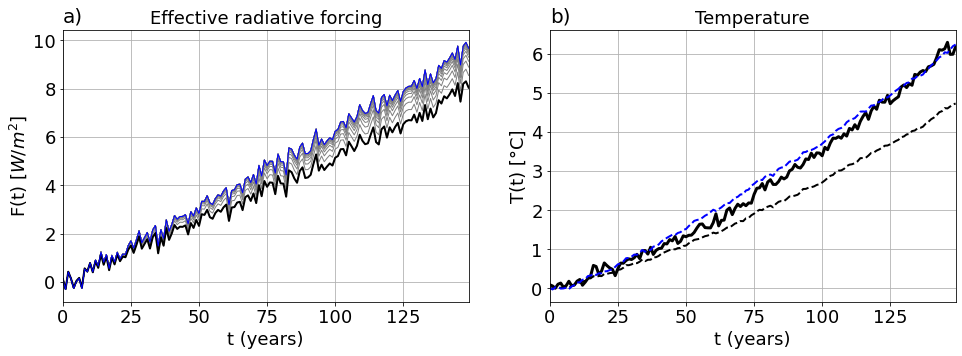

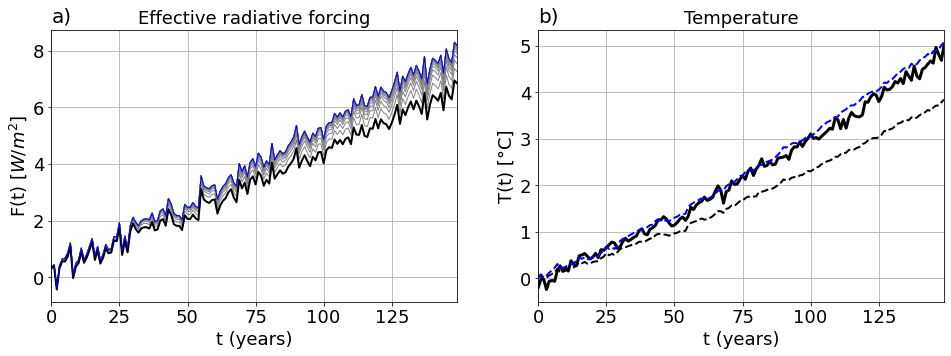

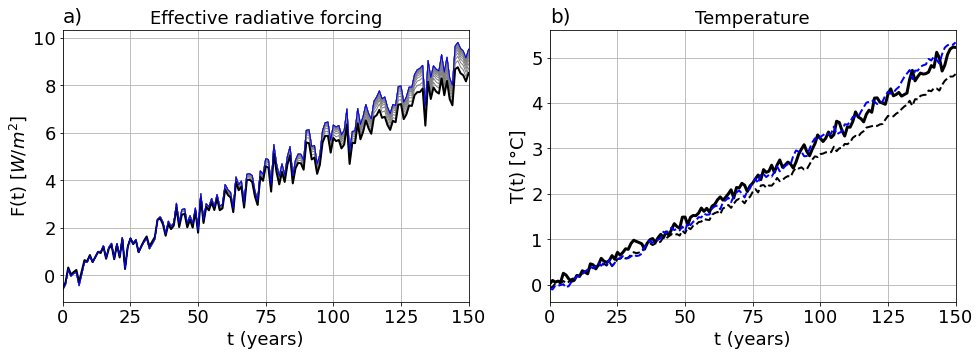

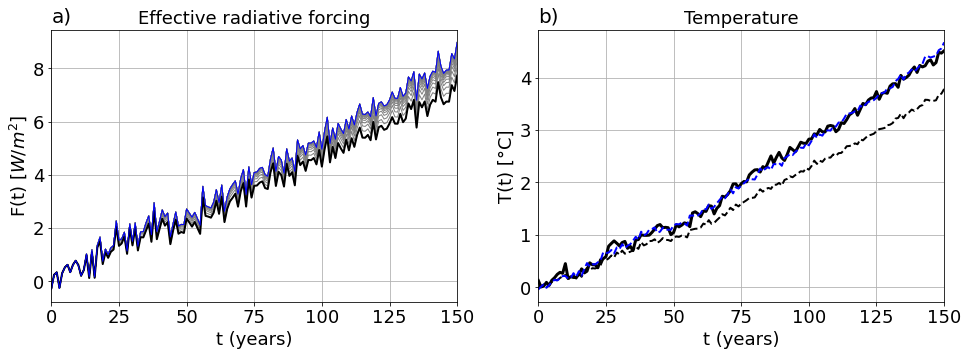

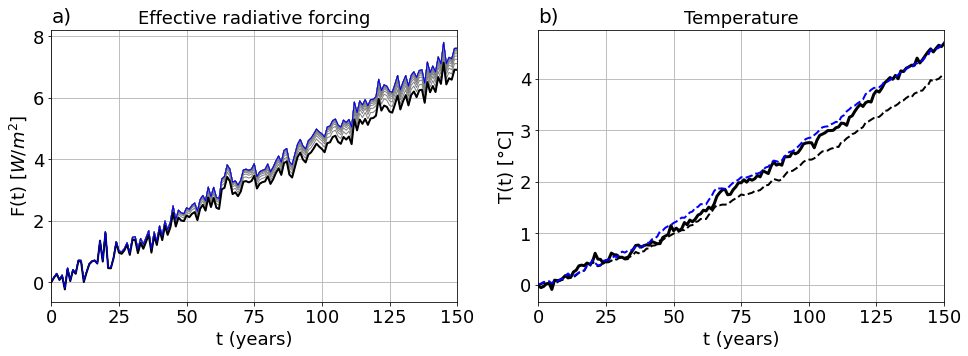

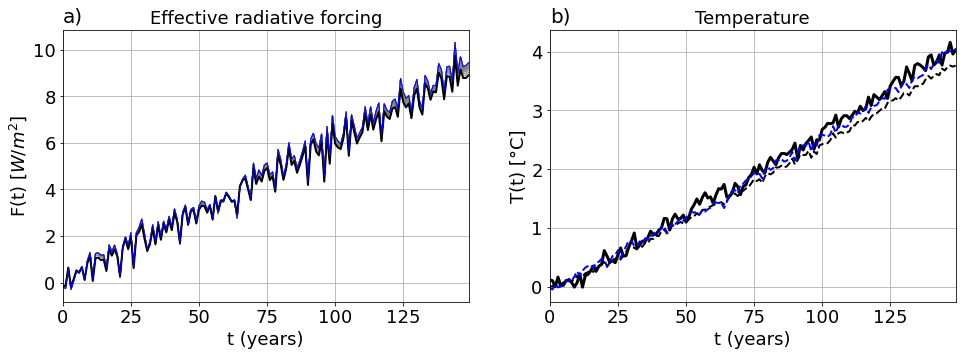

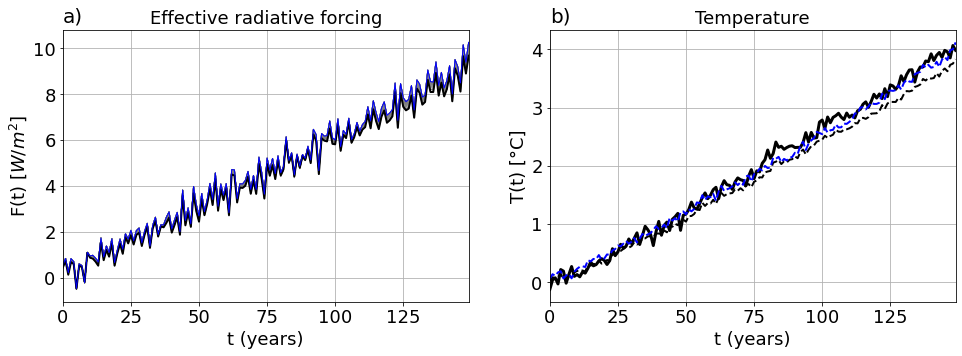

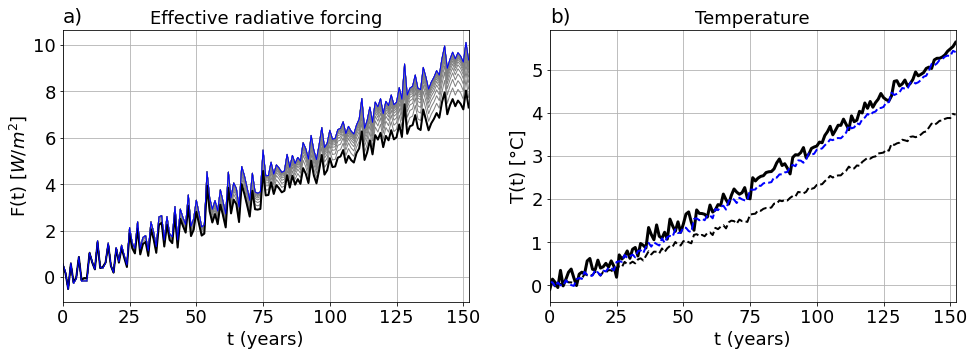

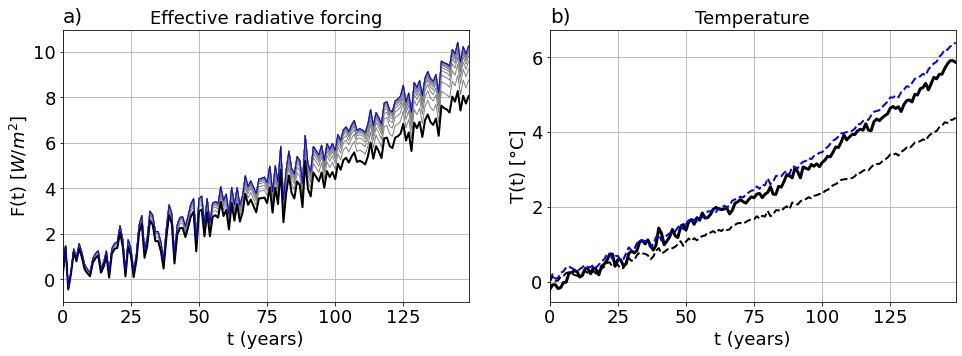

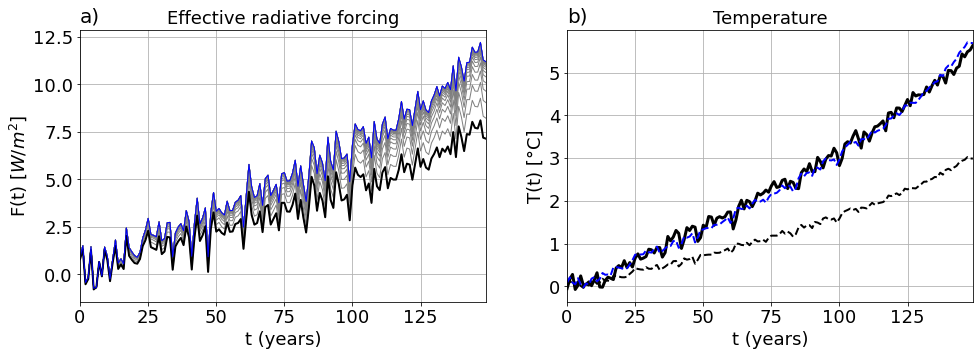

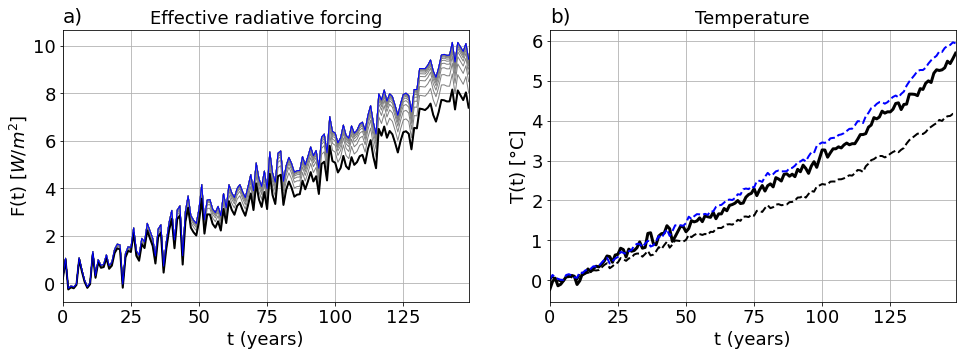

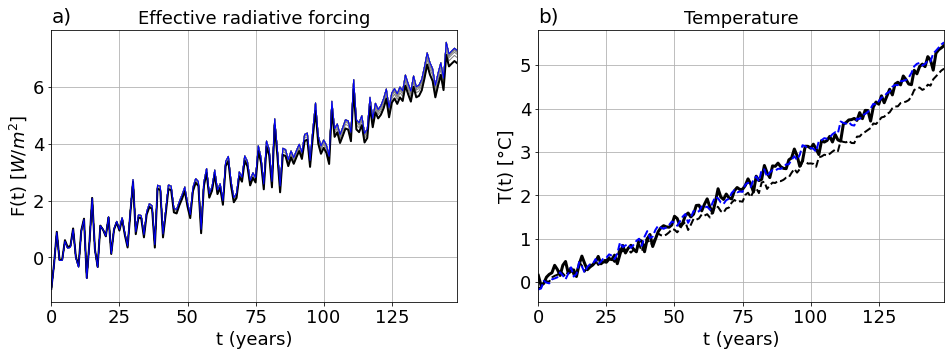

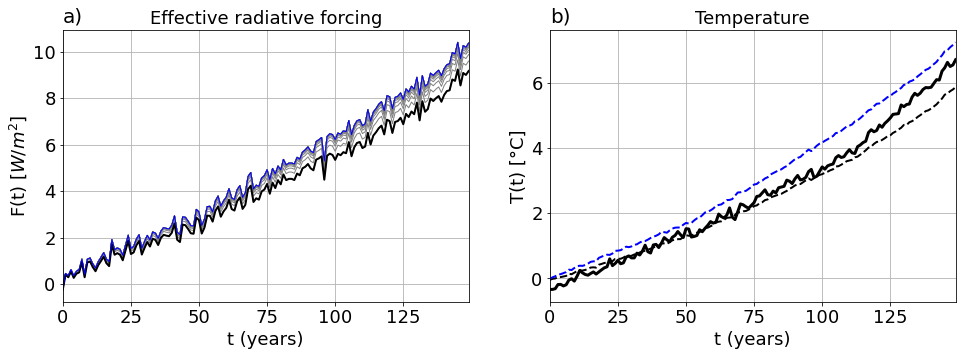

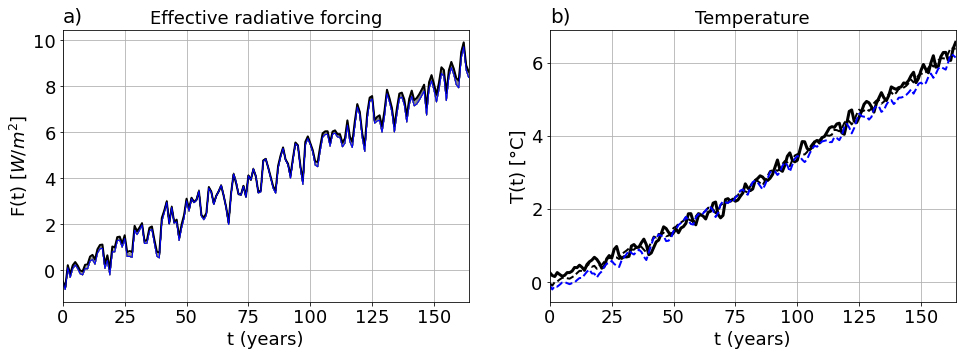

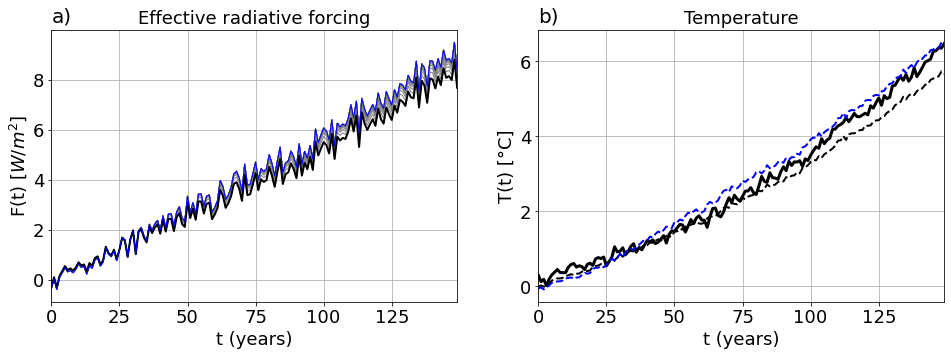

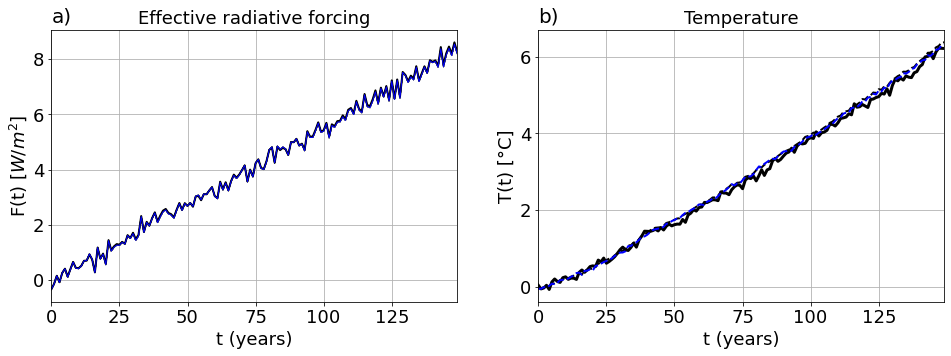

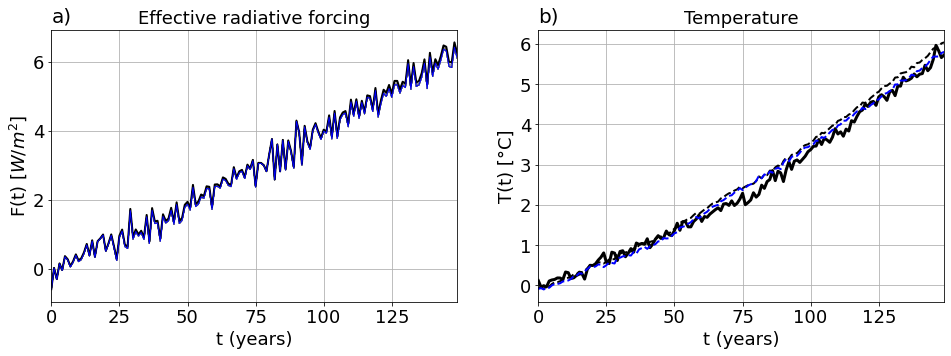

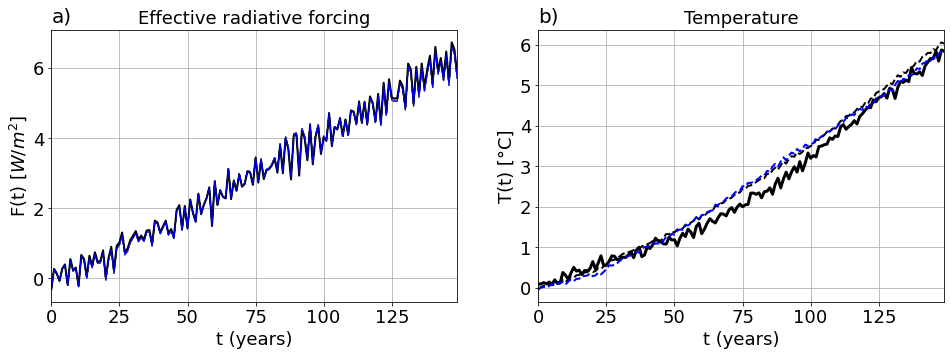

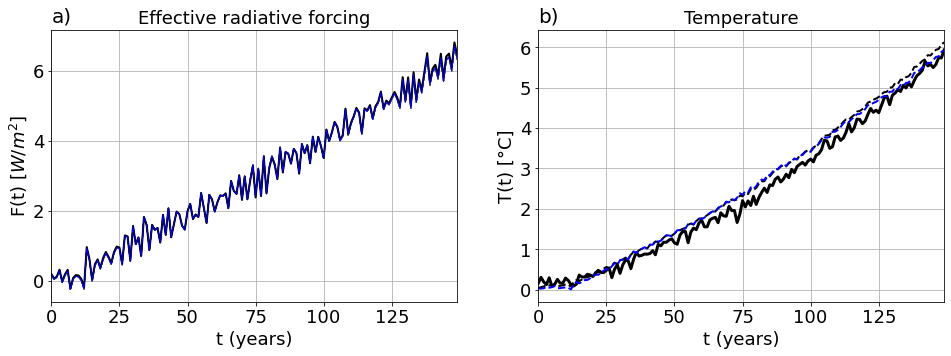

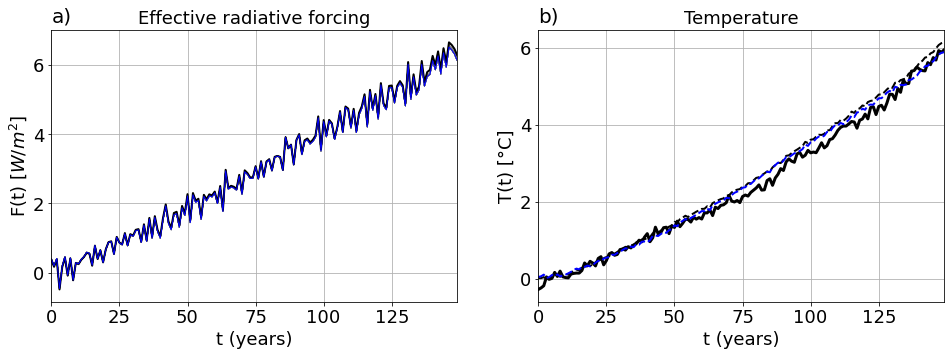

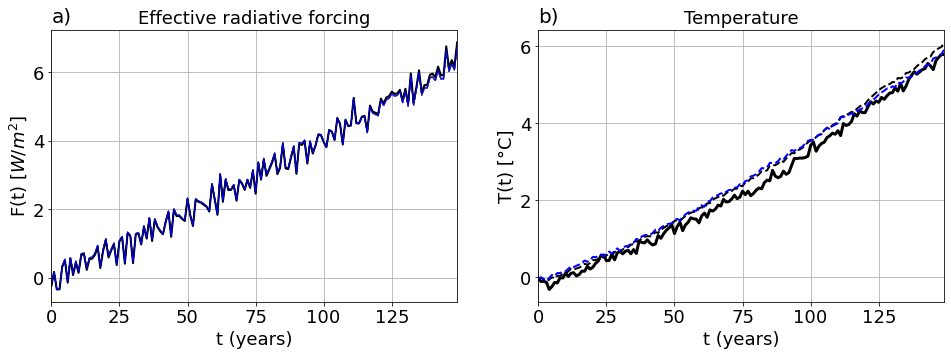

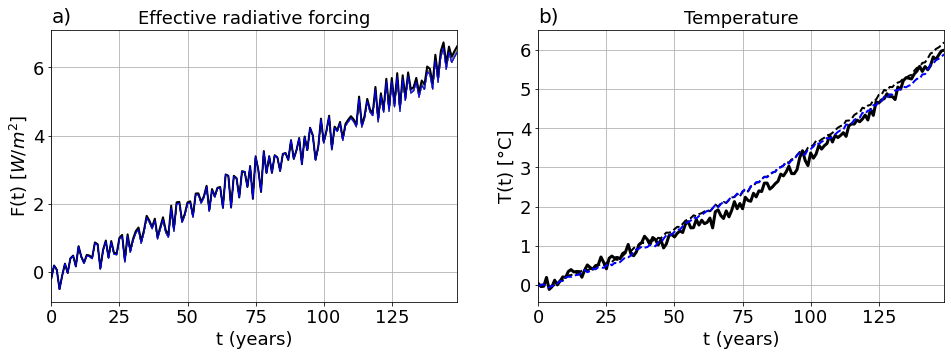

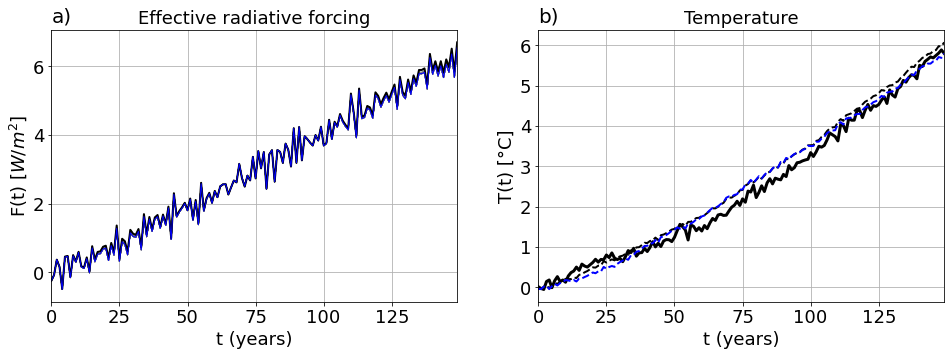

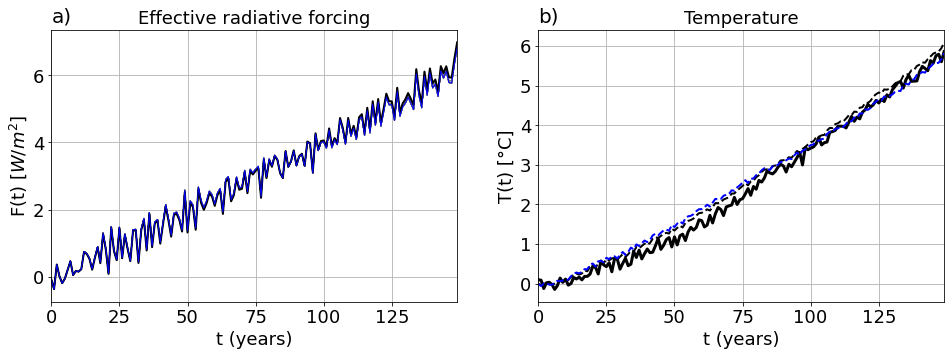

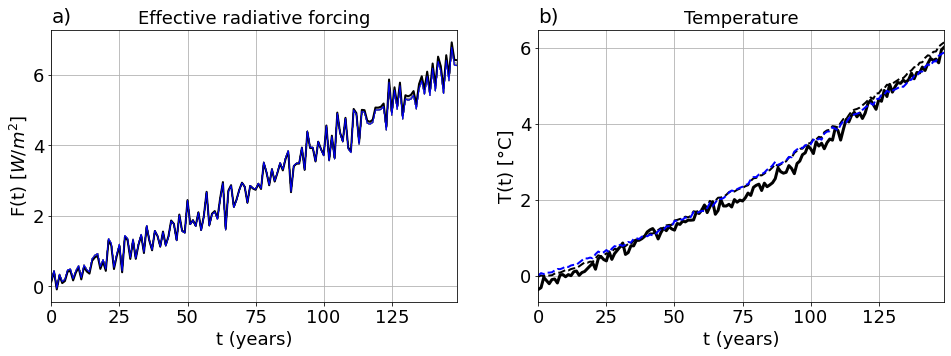

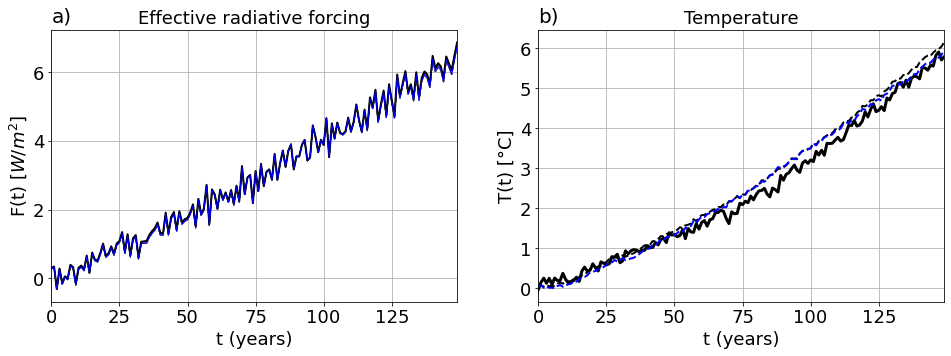

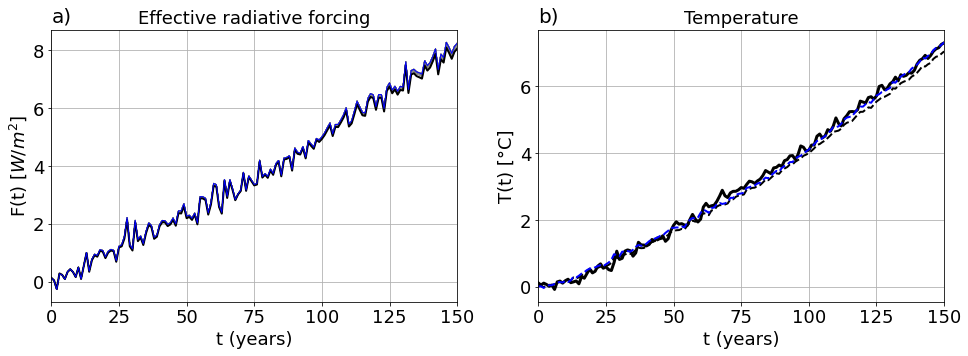

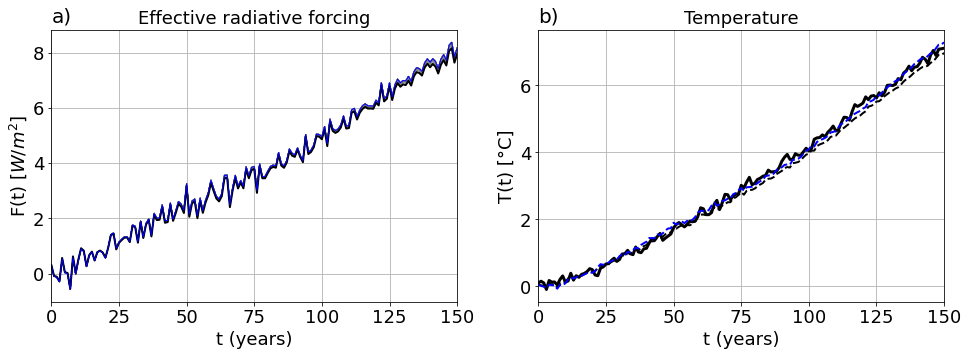

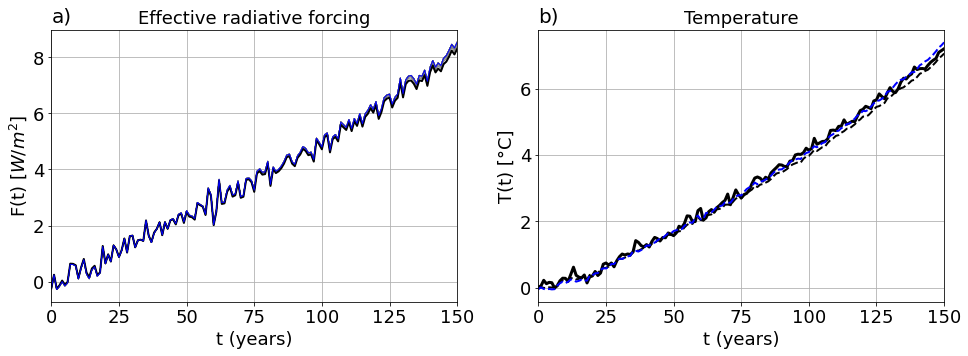

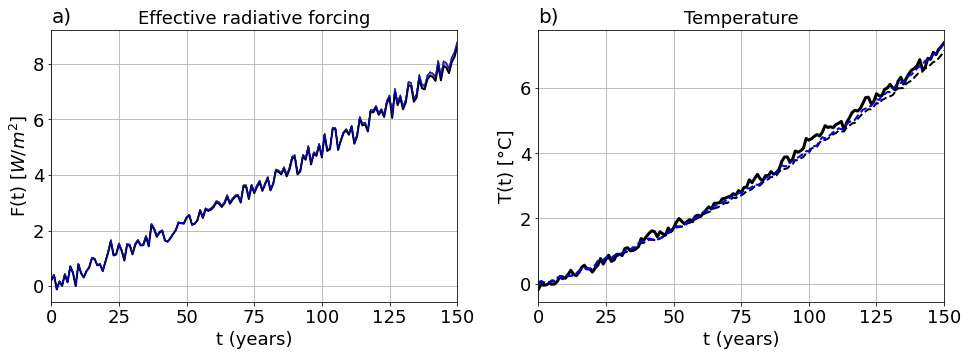

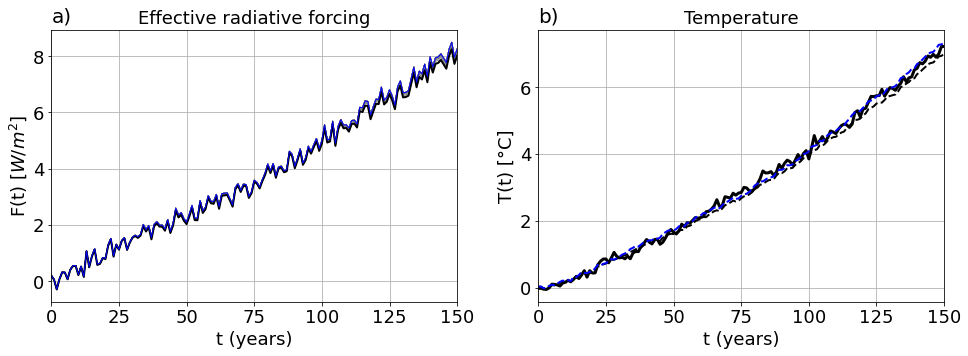

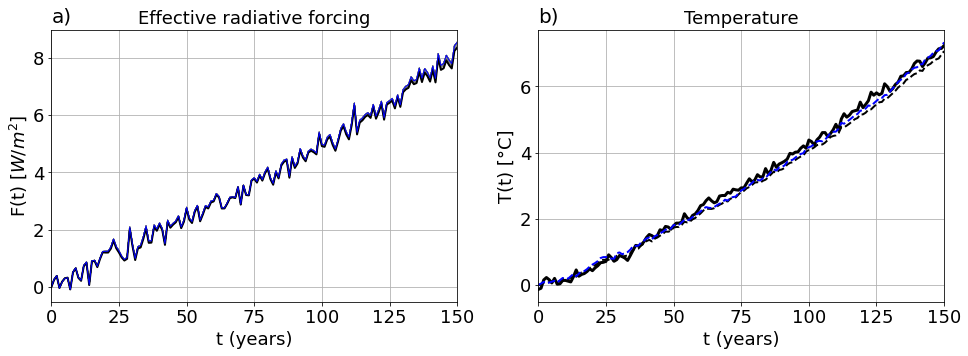

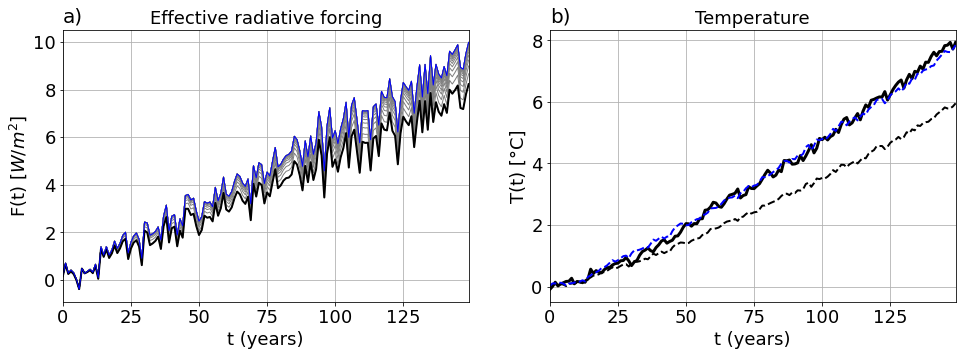

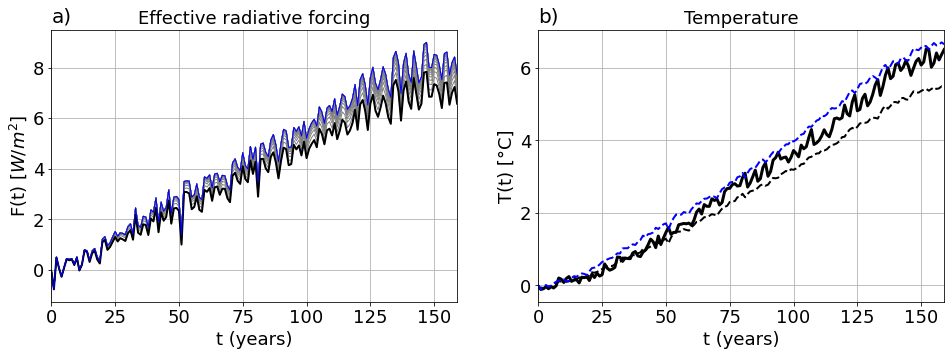

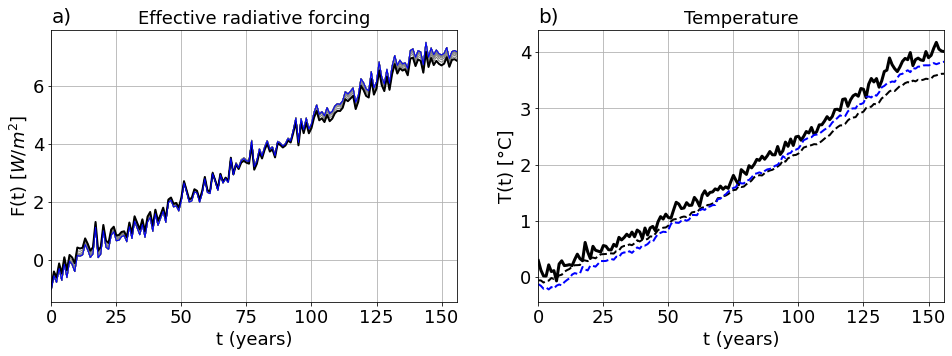

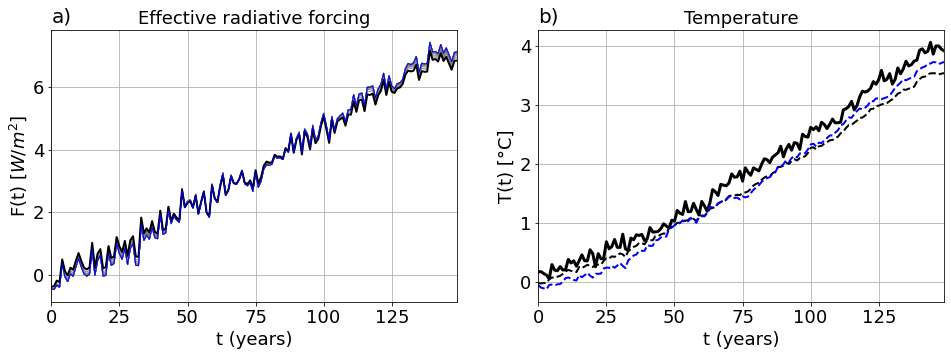

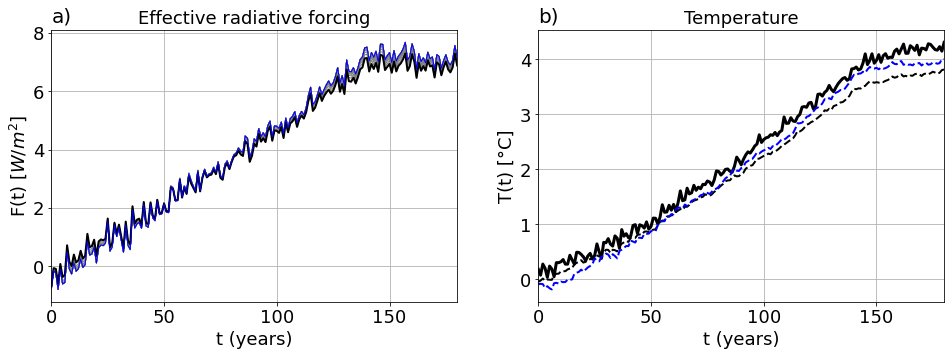

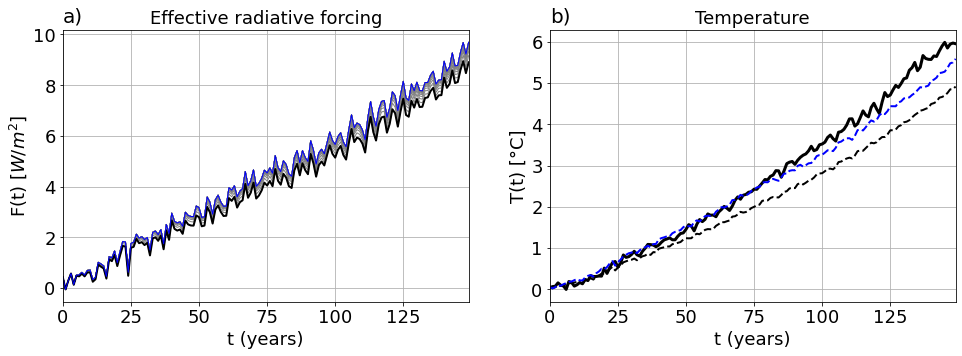

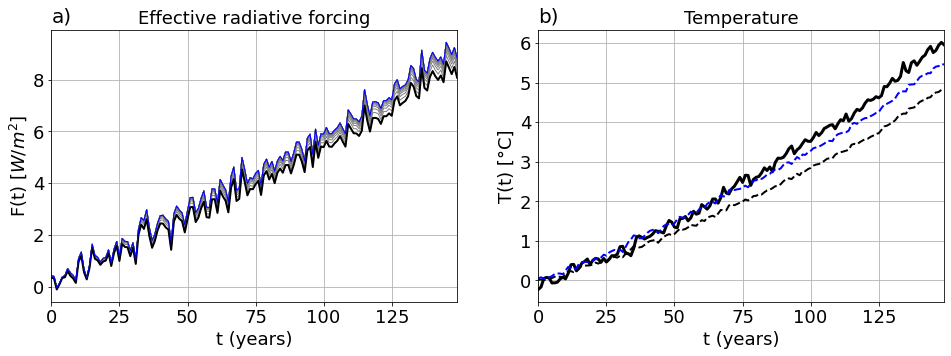

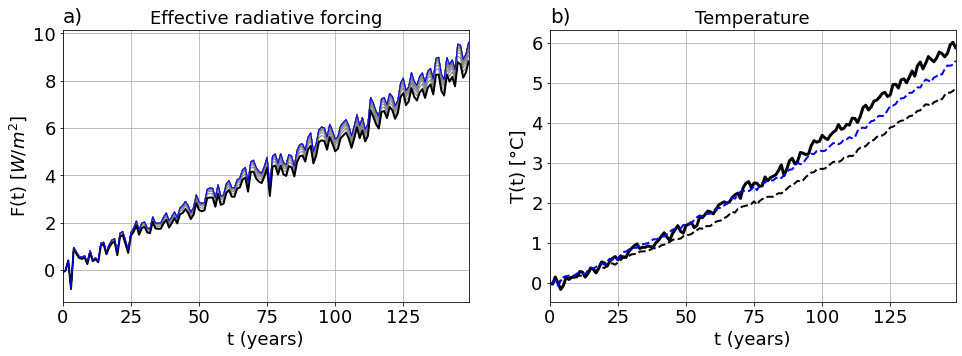

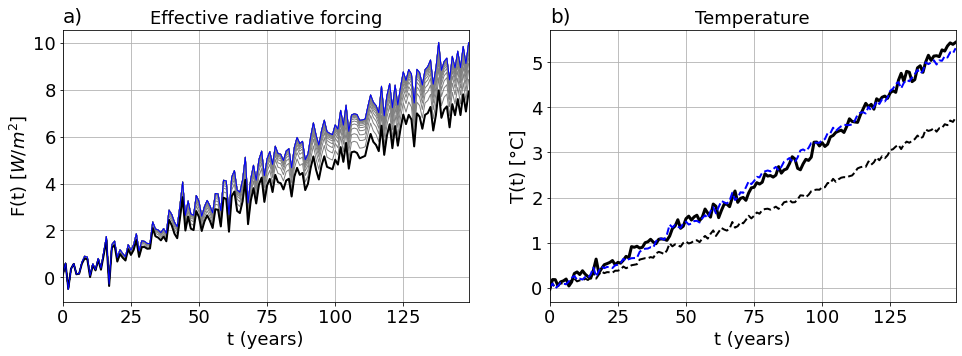

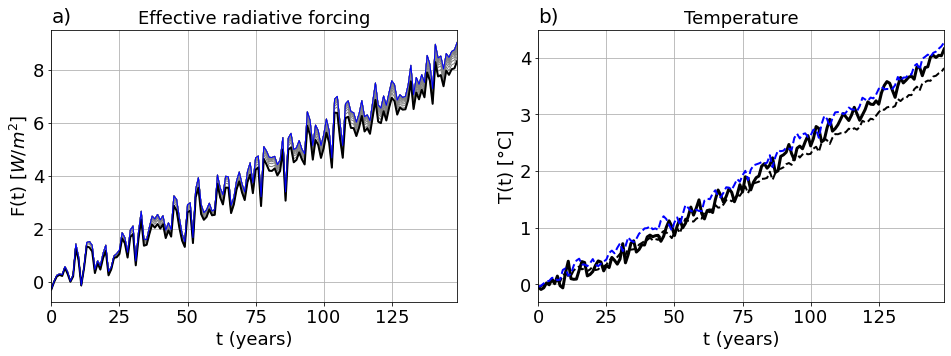

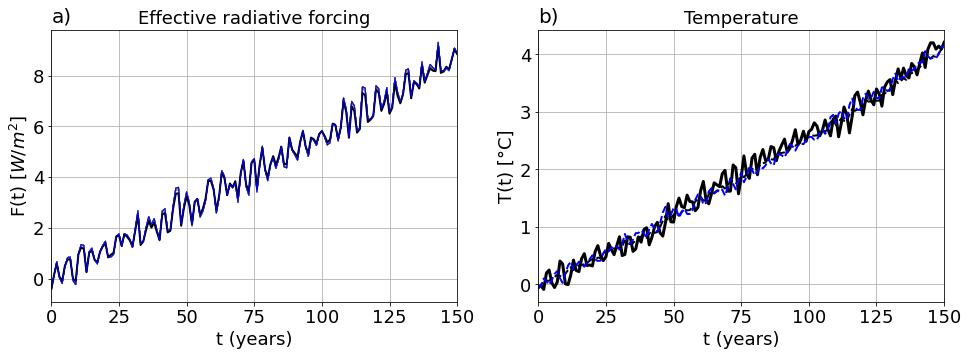

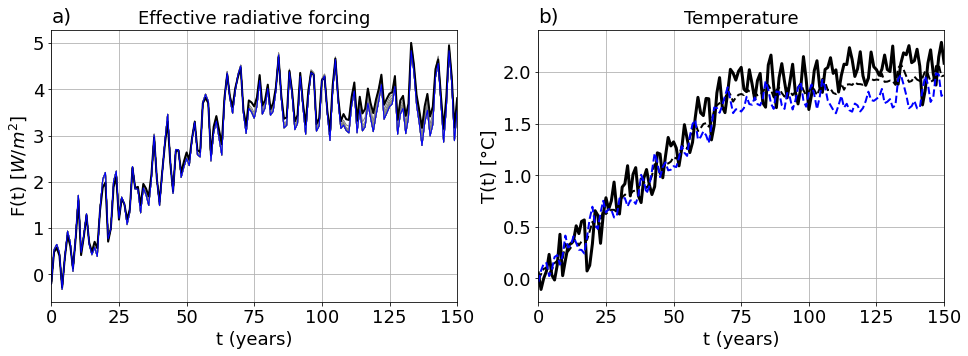

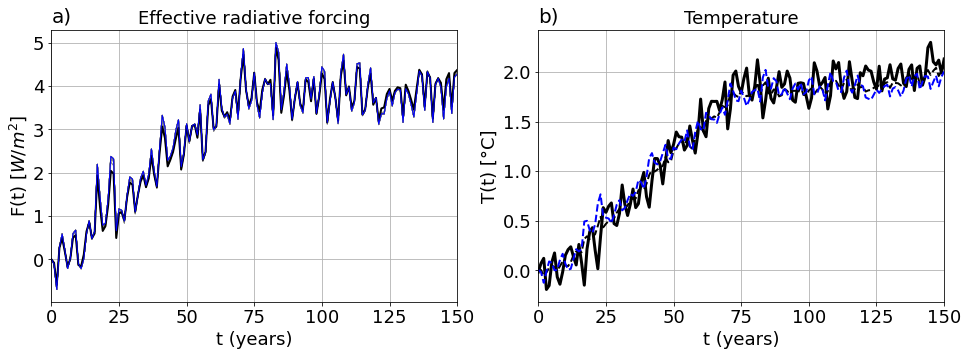

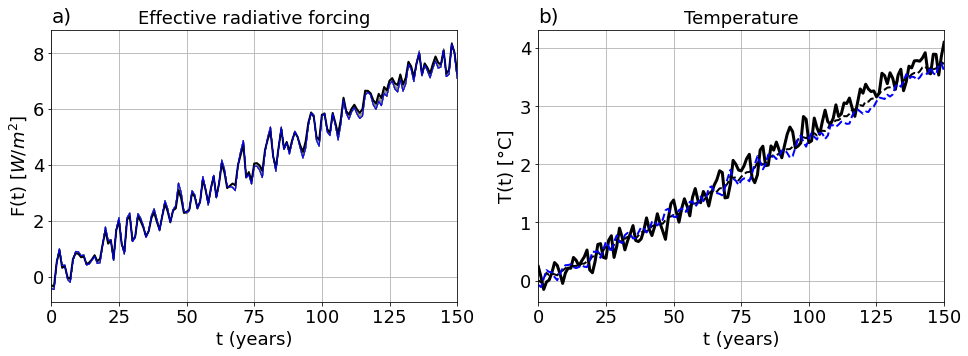

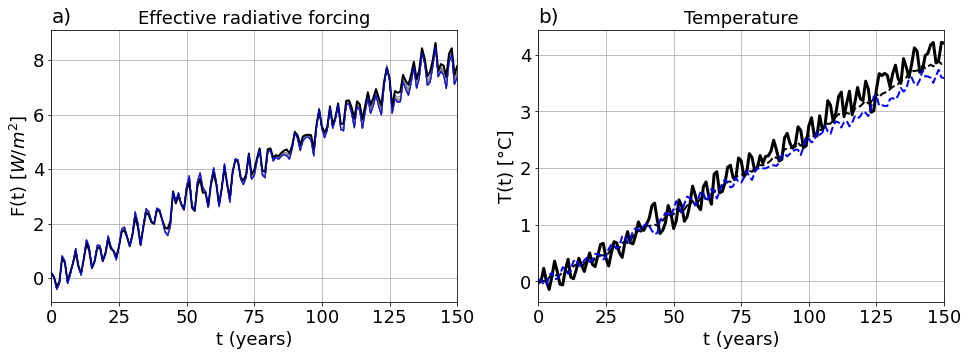

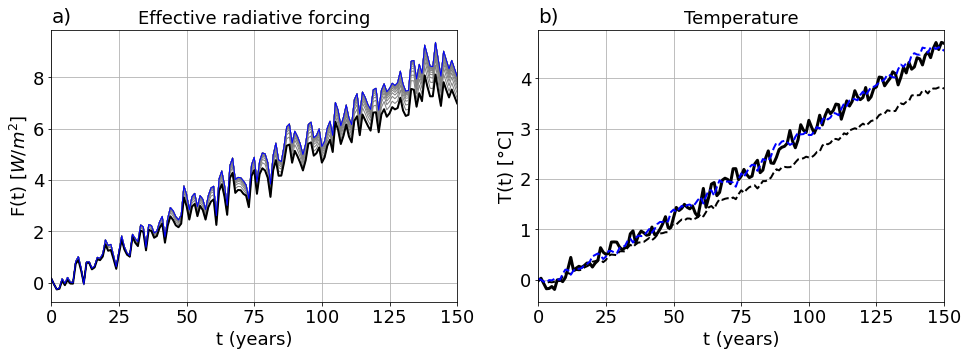

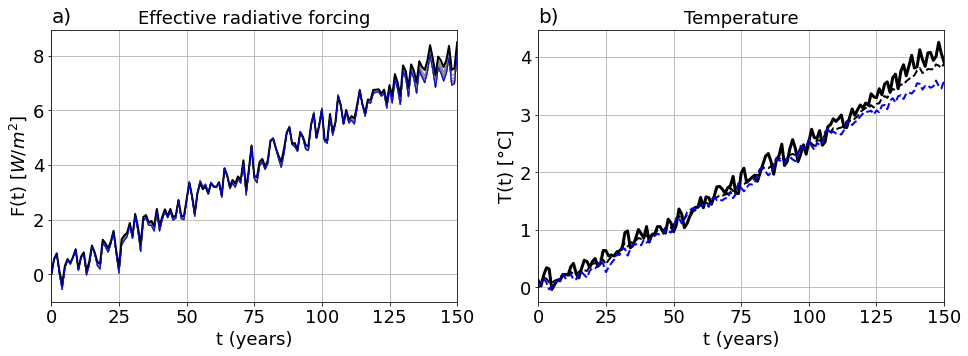

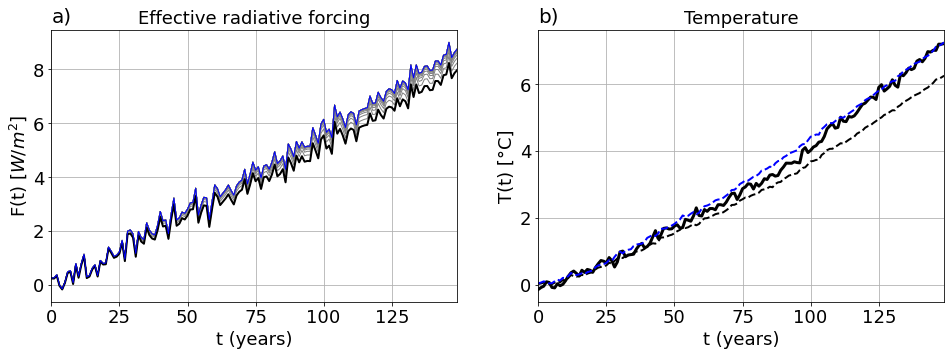

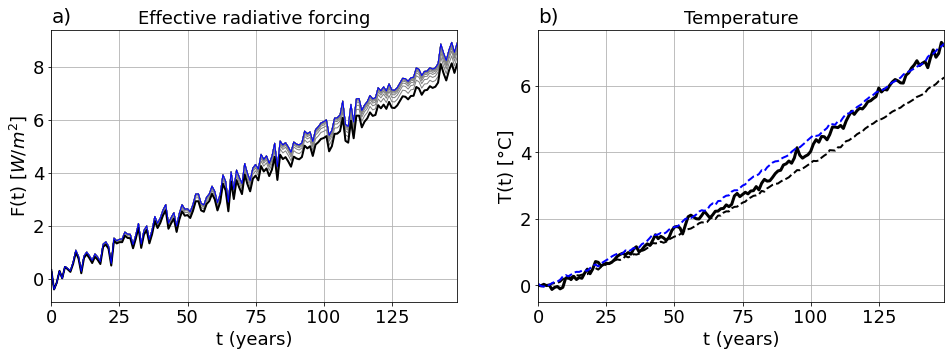

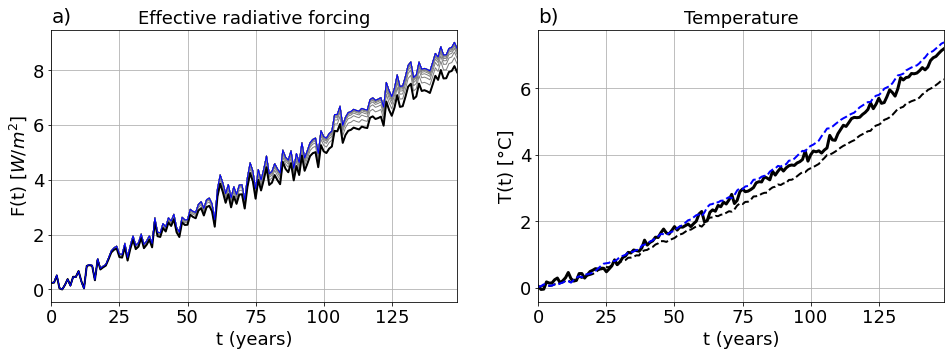

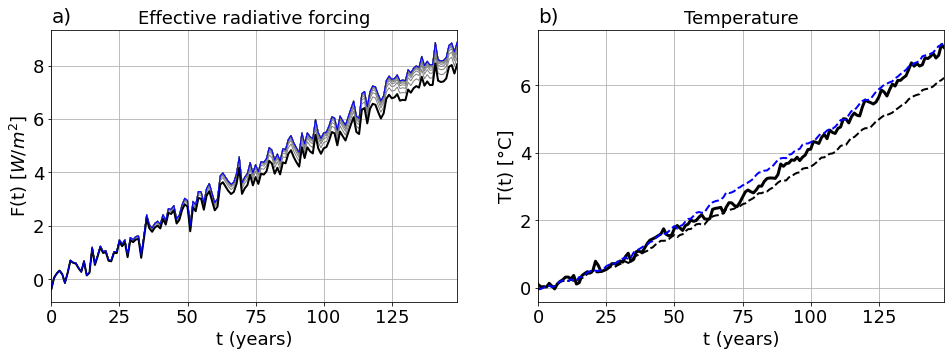

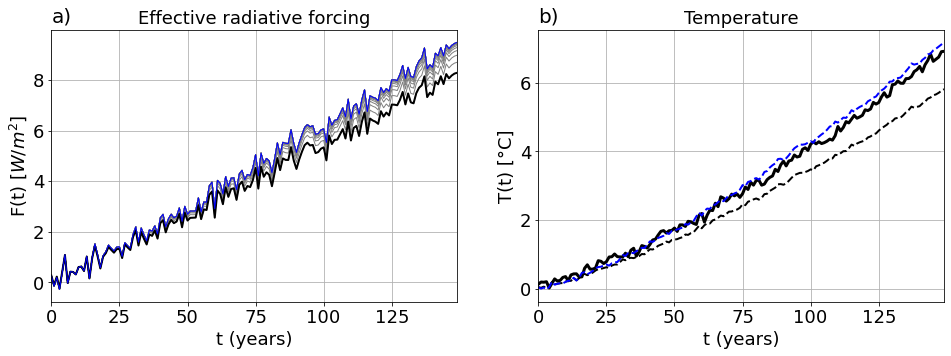

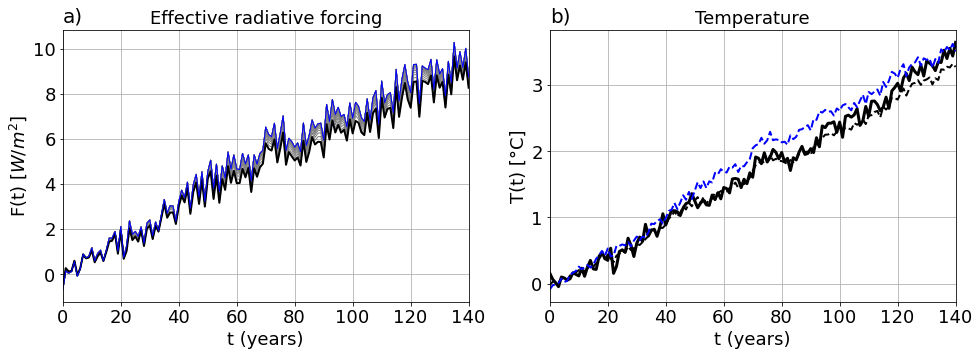

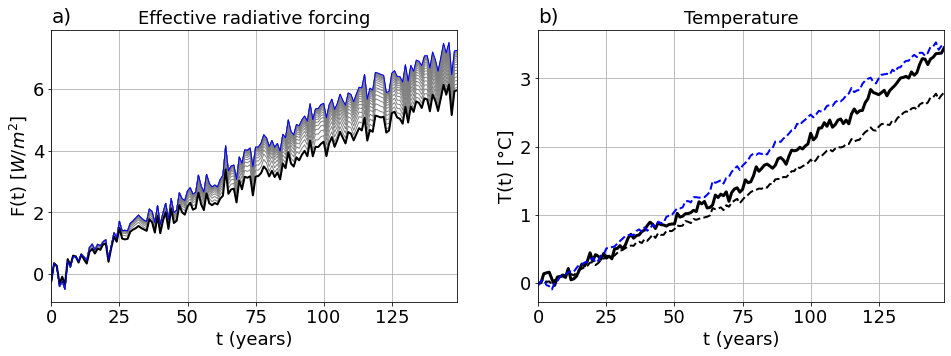

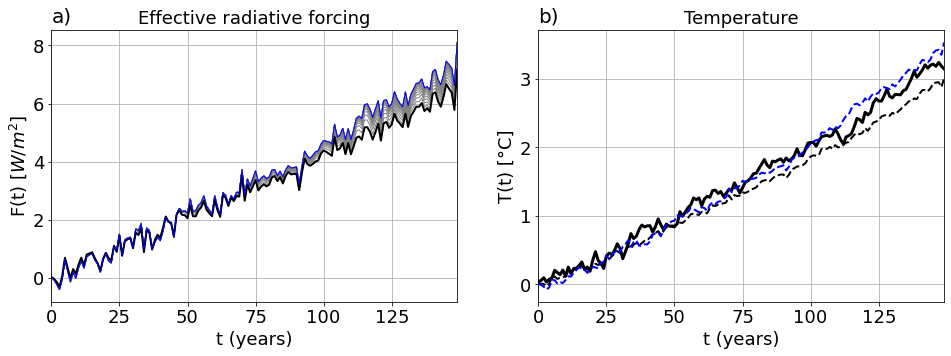

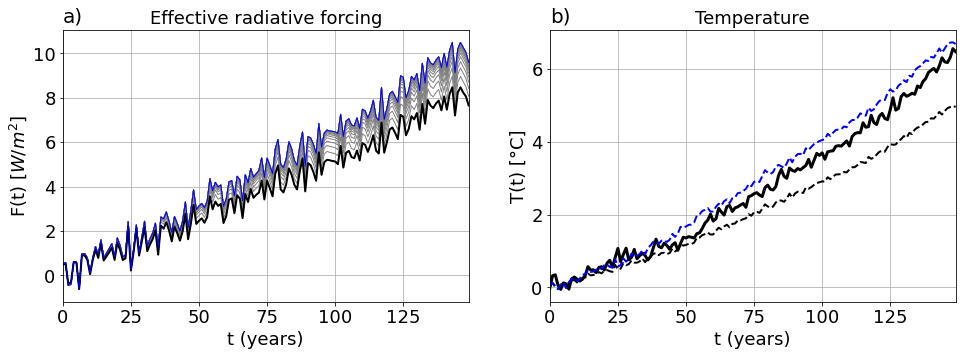

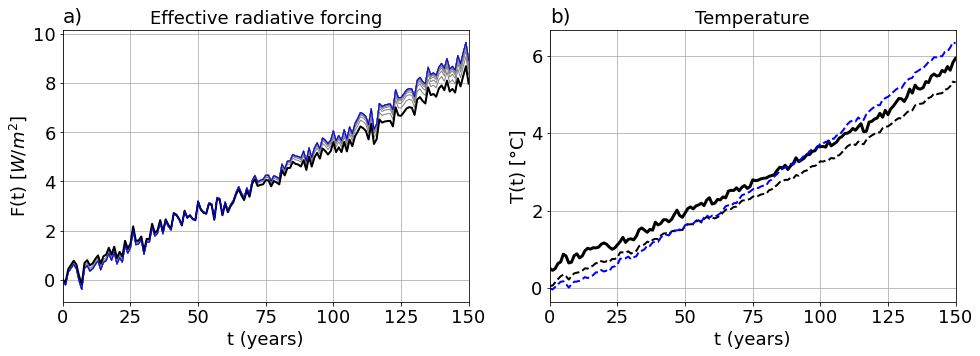

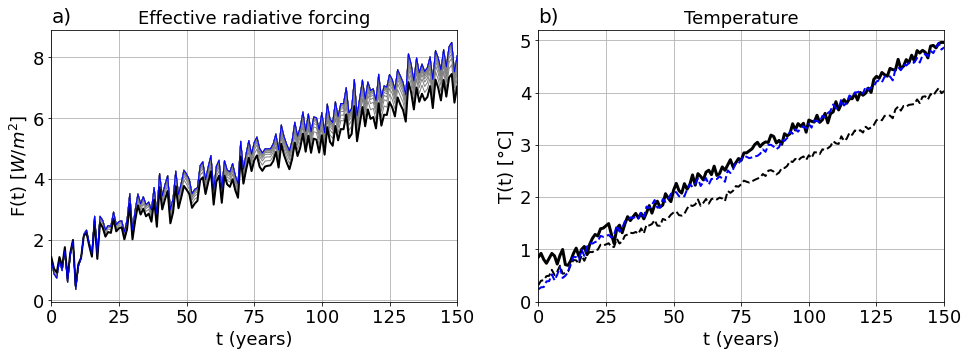

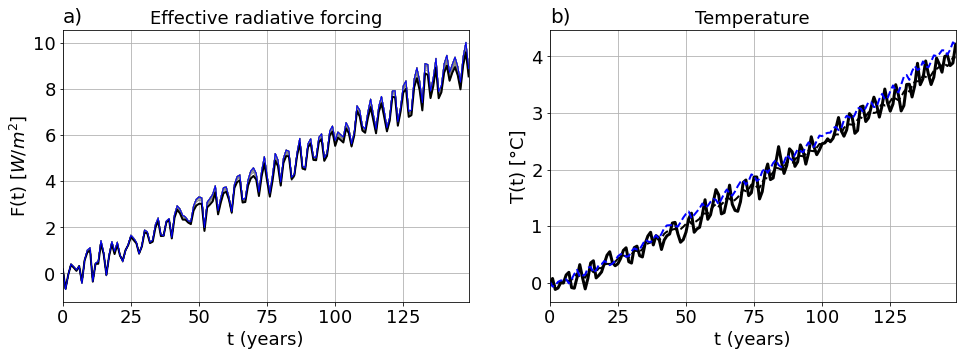

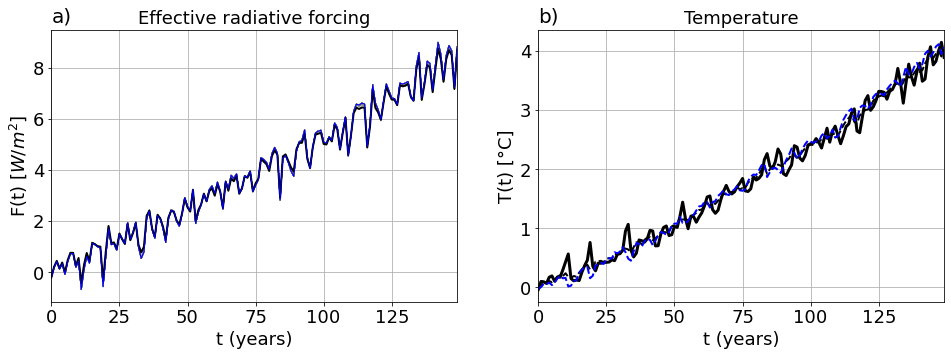

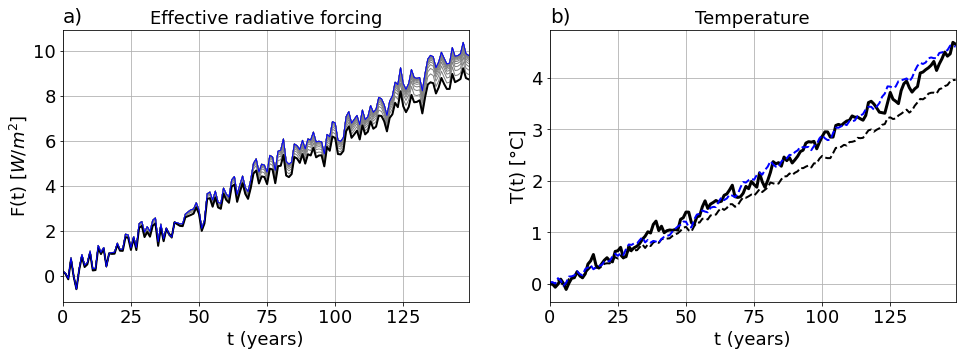

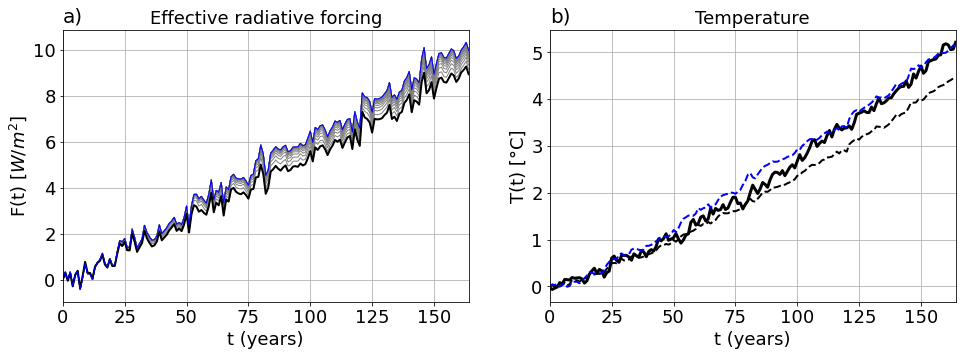

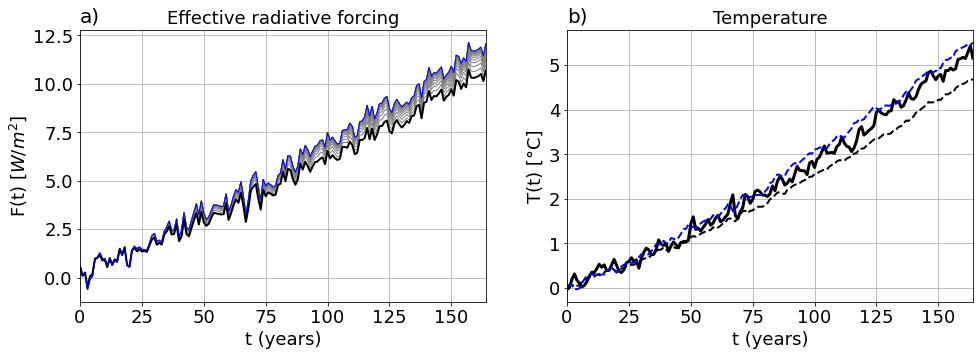

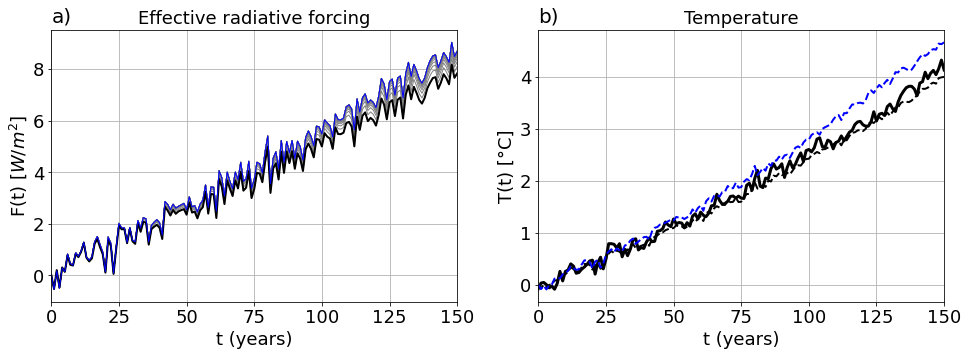

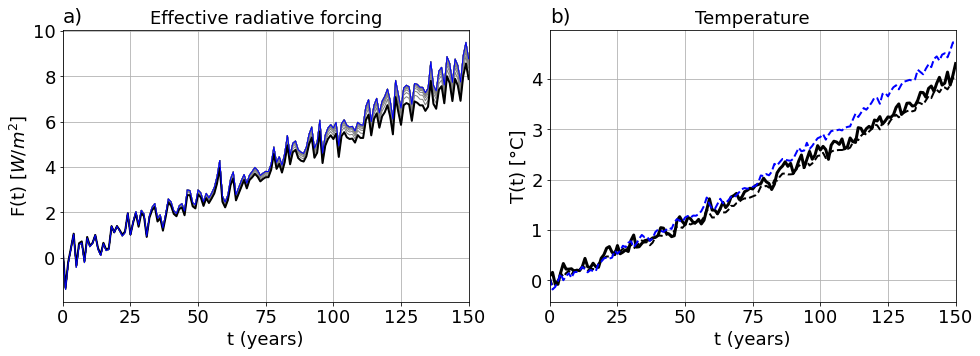

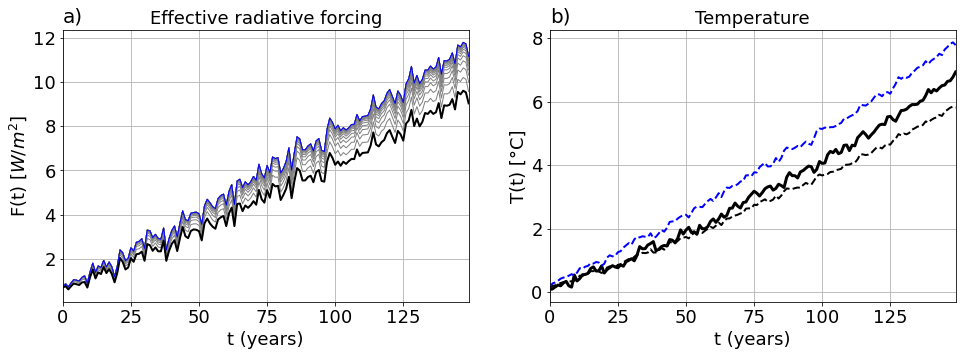

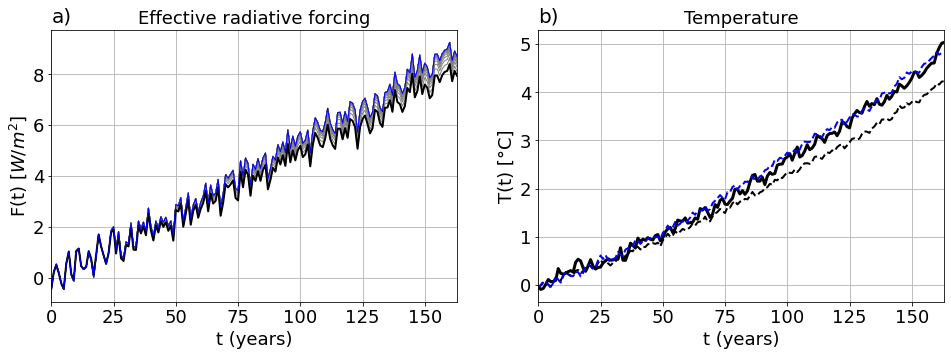

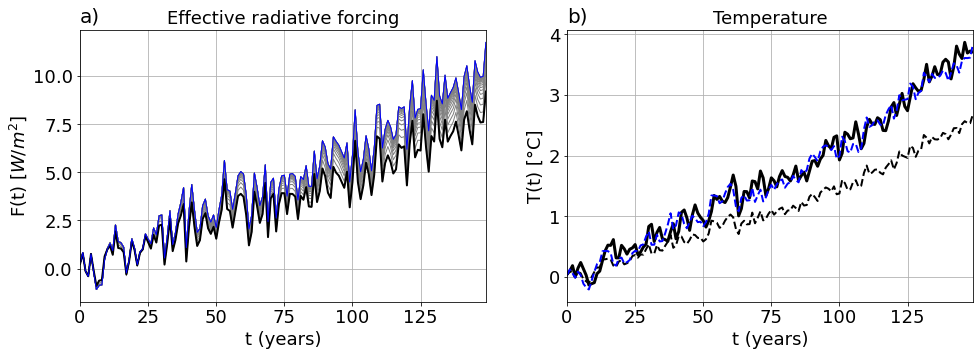

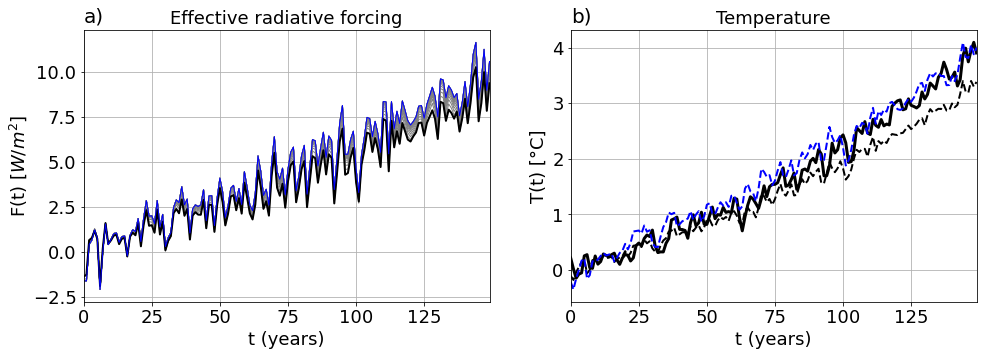

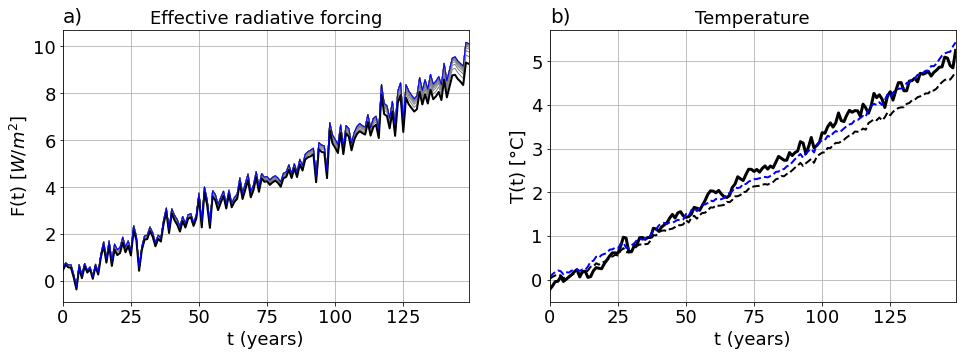

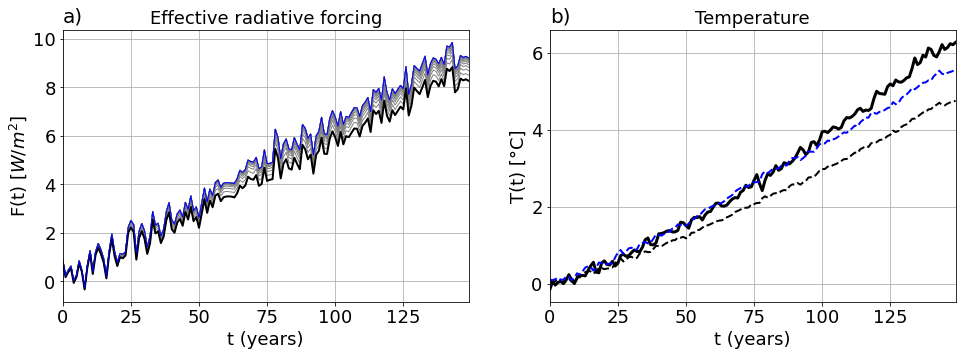

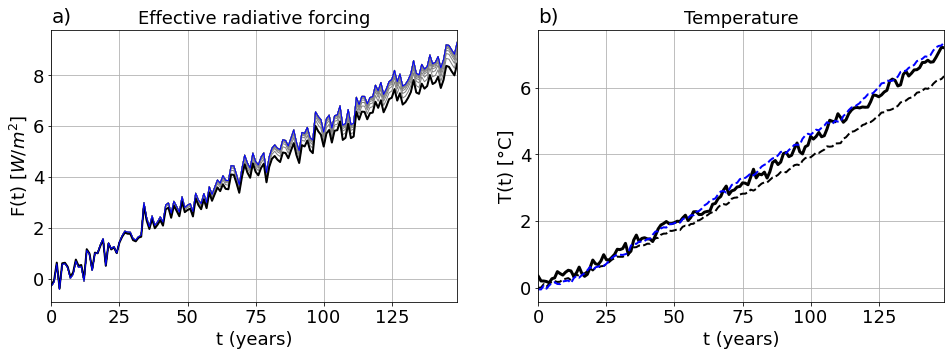

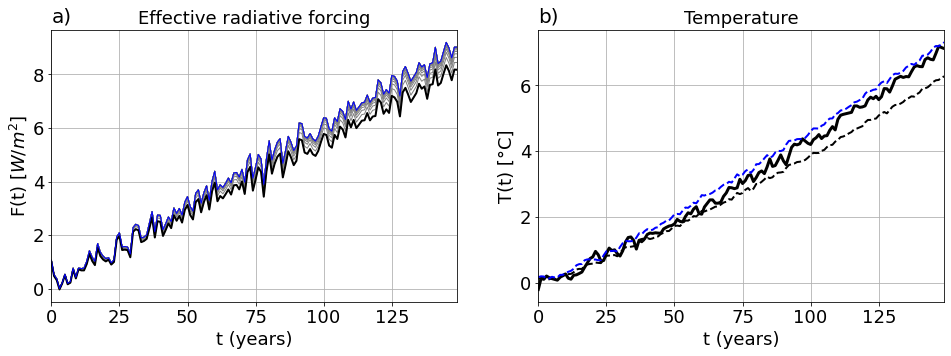

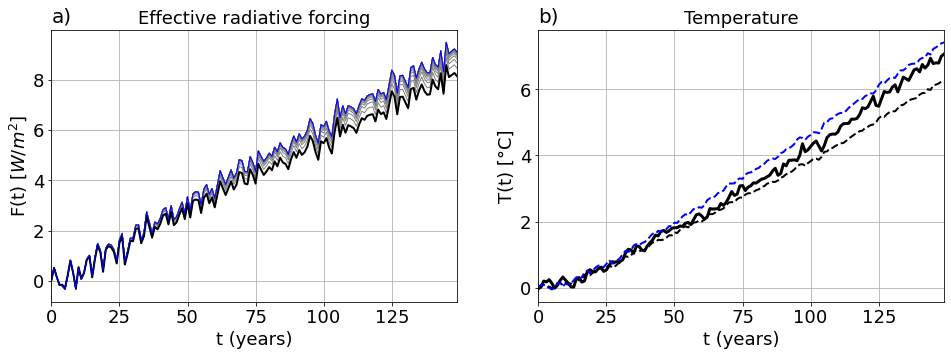

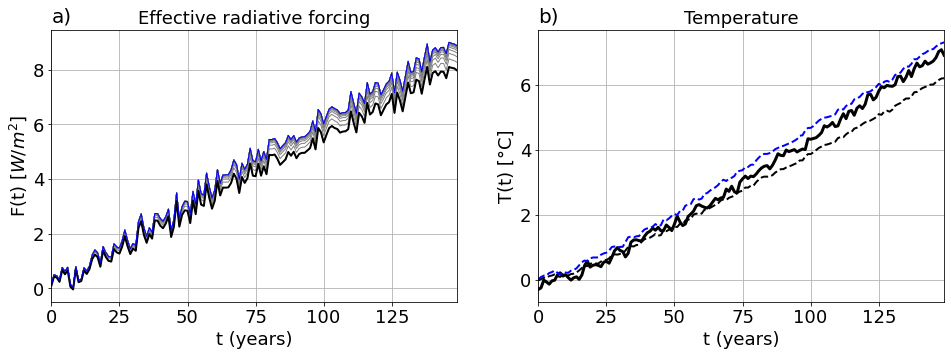

In [4]:
units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']
importlib.reload(f)
exp = '1pctCO2'

for model in models:
#for model in ['UKESM1-0-LL']:
    members = f.find_members(model, exp)
    for member in members:
    #for member in ['r1i1p1f2']:

        data = f.load_anom(model, exp, member)
        N = data['rsdt'] - data['rsut'] - data['rlut']
        years = np.arange(0, len(data));
        #variables = list(data)

        #f.plot_allvar_preloaded(years, data, model, member, plot_title = model + ' ' + exp + ' ' + member)
        #f.plot_tasandN(years, data['tas'], N, plot_title = model + ' ' + exp + ' ' + member)

        F = f.forcing_F13(data['tas'], N, model)

        # load parameters needed to make new forcing estimate:
        filename = 'best_estimated_parameters_allmembers.txt'

        parameter_table = pd.read_table('../Estimates/' + filename,index_col=0)
        taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
        a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
        b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
        F2x = parameter_table.loc[model,'F2x']
        T2x = parameter_table.loc[model,'T2x']

        dim = len(taulist)
        if any(a_n == 0):
            dim = np.count_nonzero(a_n[:dim])
            zeroindex = np.where(a_n == 0)[0]
            a_n = np.delete(a_n,zeroindex)
            b_n = np.delete(b_n,zeroindex)
            taulist = np.delete(taulist,zeroindex)
        fbparlist = (b_n/a_n)[:dim]
        amplitudes = a_n[:dim]/(2*F2x*taulist)

        t = np.arange(0,len(F))
        #tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = F)
        #Tn = amplitudes*tas_pred

        # Compute new estimate of forcing
        it = 20  # number of iterations
        Fiarray = np.full((len(F),it),np.nan)
        Tiarray = np.full((len(F),it),np.nan)

        Fi = F
        for i in range(0,it):
            tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing',\
                                        timevaryingforcing = Fi)
            Tni = amplitudes*tas_pred
            Fi = N + Tni@fbparlist
            Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

        #f.plot_components(years, Tn, taulist)

        f.forcing_response_figure(years, Fiarray, Tiarray, Tcoupled = data['tas'], model = model)

        if saveforcingfigure == True:
            plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")
        #plt.close()

        if saveforcingdata == True:
            # create model directory if it does not already exist
            if os.path.isdir('../Estimates/Transient_forcing_estimates/' + model) == False:
                os.makedirs('../Estimates/Transient_forcing_estimates/' + model)
            index = pd.Index(years, name='Year')

            # save files
            df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
            modelfilename = model + '_1pctCO2_' + exp + '_' + member + '_F13_ERF.txt'
            df_F13.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')

            df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
            modelfilename = model + '_1pctCO2_' + exp + '_' + member + '_ERF.txt'
            df_F.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')

        if save_tasdiff == True:
            # save difference between linear response to new forcing and coupled model tas
            tas_diff = Tiarray[:,-1] - data['tas']
            index = pd.Index(years, name='Year')
            df_tas = pd.DataFrame(tas_diff.values, index=index, columns=['tas_diff'])
            tas_filename = model + '_1pctCO2_' + exp + '_' + member + '_tas_diff.txt'
            df_tas.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + tas_filename, sep='\t')


